In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats
import numpy as np
import os

In [2]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [3]:
plt.rc('legend', fontsize=10)

In [4]:
dt = 0.1
ms_to_index = lambda ms: int(ms / dt)
index_to_ms = lambda ind: ind * dt

In [5]:
voltage_traces = []
currents = []

In [6]:
# decreasing.dat (XPP)
t, v = np.genfromtxt('decreasing.dat').transpose()[:2]
start = ms_to_index(550)
while start < len(v):
    # Insert voltage traces in reverse order, so that the complete array has increasing currents in the end. 
    voltage_traces = [v[start:start+ms_to_index(490)]] + voltage_traces  # trim 100 ms at start and 10 ms at end
    start += ms_to_index(500)
    
currents += [-2.72, -2.5, -2.2]
num_decreasing = len(currents)

In [7]:
# increasing.dat (XPP)
t, v = np.genfromtxt('increasing.dat').transpose()[:2]
start = ms_to_index(3050)
while start < len(v):
    voltage_traces.append(v[start:start+ms_to_index(490)])  # trim 100 ms at start and 10 ms at end
    start += ms_to_index(500)
    
currents += [-1.9, -1.5, -1.1, -0.7, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 56.69, 57.69, 58.69, 59.69]

In [8]:
currents = np.array(currents)

In [9]:
len(currents), len(voltage_traces)

(23, 23)

In [10]:
# Extract spike times via voltage threshold.
threshold = -25

spike_times = []
for v in voltage_traces:
    current_spike_times = []
    for i in range(v.size-1):
        if v[i] < threshold and v[i+1] >= threshold:
            current_spike_times.append(index_to_ms(i))
    spike_times.append(np.array(current_spike_times))

# Calculate durations between spikes and frequencies.
inter_spike_intervals = [times[1:] - times[:-1] for times in spike_times]  # ms
frequencies = [1000. / x for x in inter_spike_intervals]  # Hz

mean_frequencies = map(np.mean, frequencies)
sem_frequencies = map(sp.stats.sem, frequencies)

In [11]:
currents[:7]

array([-2.72, -2.5 , -2.2 , -1.9 , -1.5 , -1.1 , -0.7 ])

D:\Python\27_32bit\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: divide by zero encountered in log


0.0

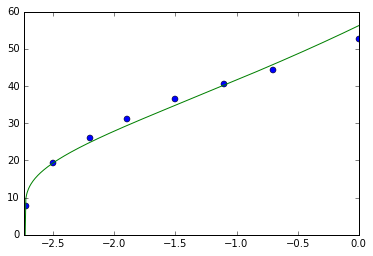

In [12]:
# Make inverse logarithmic fit for frequencies that crosses zero at -2.73 pA.
# In addition to the slope, the fit function includes a scaling parameter that was trimmed by hand,
# compare Izhikevich 2007, fig. 6.30 on p. 189.

# First, try to make a manual fit.
x = np.log(currents[:7] - (-2.73) + 1)
y = mean_frequencies[:7]

plt.plot(currents, np.array(mean_frequencies), 'o')
a = np.linspace(-2.73, 0, 500)
f = lambda x: -73./np.log(0.1*(x--2.73))
plt.plot(a, f(a))
plt.xlim(-2.74, 0)
plt.ylim(0, 60)
f(-2.73)

73.5937061378


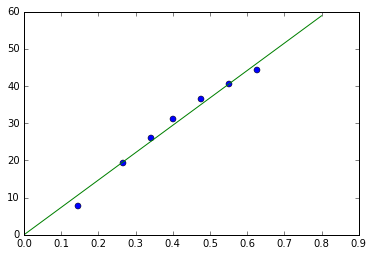

In [13]:
# Then, set the scaling parameter manually and fit the slope by least squares. 
fit_frequencies_scale = 0.1  # TODO: Fit this scaling parameter by least squares as well.

x = -1. / np.log(fit_frequencies_scale * (currents[:7] + 2.73))
y = mean_frequencies[:7]

# See http://stackoverflow.com/a/9994484
a, _, _, _ = np.linalg.lstsq(x[:, np.newaxis], y)
fit_frequencies_slope = a[0]
print fit_frequencies_slope

# Plot result of the least squares fit. 
plt.plot(x, y, 'o')
b = np.linspace(0, 0.8, 500)
plt.plot(b, fit_frequencies_slope * b)

D:\Python\27_32bit\lib\site-packages\ipykernel\__main__.py:14: RuntimeWarning: divide by zero encountered in log
D:\Python\27_32bit\lib\site-packages\ipykernel\__main__.py:35: RuntimeWarning: divide by zero encountered in log


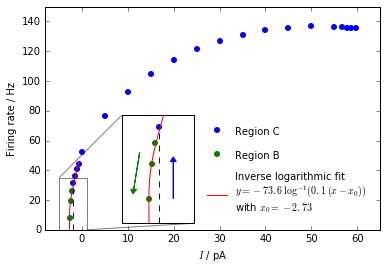

In [14]:
#plt.axvline(-1.90+12, label="Rheobase (silence -> tonic)", color='b', alpha=0.6)
#plt.text(11.4, 120, '10.10 pA', color='b', rotation=90)
plt.plot(currents[num_decreasing:], mean_frequencies[num_decreasing:], 'bo', label="Region C", markeredgecolor='none')  # yerr=sem_frequencies
#plt.arrow(1, 8, 0, 12, head_width=1, head_length=3, fc='b', ec='b')

plt.vlines(currents[num_decreasing], 0, mean_frequencies[num_decreasing], 'b', 'dashed', zorder=100)

#plt.axvline(-2.73+12, label="Rheobase (tonic -> silence)", color='g', alpha=0.6)
#plt.text(6.5, 120, '9.27 pA', color='b', rotation=90)
plt.plot(currents[:num_decreasing], mean_frequencies[:num_decreasing], 'go', label="Region B", markeredgecolor='none')  # yerr=sem_frequencies_2
#plt.arrow(-5, 22, -0.5, -10, head_width=1, head_length=3, fc='g', ec='g')

x = np.linspace(-2.73, -0.7, 500)
plt.plot(x, fit_frequencies_slope * -1. / np.log(fit_frequencies_scale * (x + 2.73)), 'r', zorder=10, label='Inverse logarithmic fit\n$y = - {0:.1f} \: \log^{{-1}}({1:.1f} \: (x - x_0 ))$\nwith $x_0 = -2.73$'.format(fit_frequencies_slope, fit_frequencies_scale))

plt.ylim(0, 150)
plt.xlim(-8, 65)
plt.xlabel('$I$ / pA')
plt.ylabel('Firing rate / Hz')
plt.legend(loc='lower right', numpoints=1, borderaxespad=1, frameon=False, labelspacing=1.4)

# make inset
ax = plt.gca()
axins = inset_axes(ax, 1, 1.5, bbox_to_anchor=(0.48, 0.54), bbox_transform=ax.figure.transFigure)
plt.plot(currents[num_decreasing:], mean_frequencies[num_decreasing:], 'bo', label="Region C", markeredgecolor='none')  # yerr=sem_frequencies
plt.arrow(-0.7, 8, 0, 12, head_width=0.5, head_length=1.5, fc='b', ec='b')

plt.vlines(currents[num_decreasing], 0, mean_frequencies[num_decreasing], 'b', 'dashed', zorder=100)

#plt.axvline(-2.73+12, label="Rheobase (tonic -> silence)", color='g', alpha=0.6)
#plt.text(6.5, 120, '9.27 pA', color='b', rotation=90)
plt.plot(currents[:num_decreasing], mean_frequencies[:num_decreasing], 'go', label="Region B", markeredgecolor='none')  # yerr=sem_frequencies_2
plt.arrow(-3.5, 23, -0.5, -12, head_width=0.5, head_length=1.5, fc='g', ec='g')
x = np.linspace(-2.73, -0.7, 500)
plt.plot(x, fit_frequencies_slope * -1. / np.log(fit_frequencies_scale * (x + 2.73)), 'r', zorder=10, label='Inverse logarithmic fit\n$y = - {0:.1f} \: \log^{{-1}}({1:.1f} \: (x - x_0 ))$\nwith $x_0 = -2.73$'.format(fit_frequencies_slope, fit_frequencies_scale))

plt.xlim(-5, 1)
plt.ylim(0, 35)
plt.xticks([])
plt.yticks([])
mark_inset(ax, axins, loc1=4, loc2=2, fc="none", alpha=0.5)

plt.savefig("f-I-curve.png", dpi=300)

In [15]:
# Minima, maxima and amplitudes (maxima - minima) of membrane voltage during spikes
minima = []
maxima = []
amplitudes = []

for v, times in zip(voltage_traces, spike_times):
    current_minima = []
    current_maxima = []
    current_amplitudes = []
    for i in range(len(times)-1):
        start = ms_to_index(times[i])
        end = ms_to_index(times[i+1])
        minimum = np.min(v[start:end])  # mV
        maximum = np.max(v[start:end])  # mV
        current_minima.append(maximum)
        current_maxima.append(minimum)
        current_amplitudes.append(maximum - minimum)
    minima.append(np.array(current_minima))
    maxima.append(np.array(current_maxima))
    amplitudes.append(np.array(current_amplitudes))
#zip(minima, maxima, amplitudes)

In [16]:
mean_minima = map(np.mean, [x[:-1] for x in minima])  # exclude first two spikes and last spike to eliminate effects at the start and end of the current step
sem_minima = map(sp.stats.sem, [x[:-1] for x in minima])
mean_maxima = map(np.mean, [x[:-1] for x in maxima])
sem_maxima = map(sp.stats.sem, [x[:-1] for x in maxima])
mean_amplitudes = map(np.mean, [x[:-1] for x in amplitudes])
sem_amplitudes = map(sp.stats.sem, [x[:-1] for x in amplitudes])

D:\Python\27_32bit\lib\site-packages\numpy\core\_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
D:\Python\27_32bit\lib\site-packages\numpy\core\_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


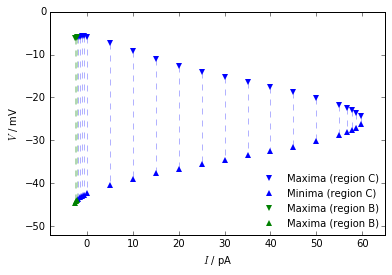

In [17]:
plt.plot(currents[num_decreasing:], mean_minima[num_decreasing:], 'bv', markeredgecolor='none', label='Maxima (region C)')  # yerr=sem_minima
plt.plot(currents[num_decreasing:], mean_maxima[num_decreasing:], 'b^', markeredgecolor='none', label='Minima (region C)')  # yerr=sem_maxima
plt.vlines(currents[num_decreasing:], mean_minima[num_decreasing:], mean_maxima[num_decreasing:], alpha=0.3, color='b', linestyle='--')

plt.plot(currents[:num_decreasing], mean_minima[:num_decreasing], 'gv', markeredgecolor='none', label='Maxima (region B)')  # yerr=sem_minima
plt.plot(currents[:num_decreasing], mean_maxima[:num_decreasing], 'g^', markeredgecolor='none', label='Maxima (region B)')  # yerr=sem_maxima
plt.vlines(currents[:num_decreasing], mean_minima[:num_decreasing], mean_maxima[:num_decreasing], alpha=0.3, color='g', linestyle='--')

plt.xlabel('$I$ / pA')
plt.ylabel('$V$ / mV')
plt.xlim(-8, 65)
plt.ylim(-52, 0)
#plt.axvline(-1.90, label="Rheobase (silence -> tonic)", color='b', alpha=0.6)
#plt.text(7, -13, '10.10 pA', color='b', rotation=90)
plt.legend(loc='lower right', numpoints=1, borderaxespad=0.2, frameon=False)

plt.savefig("min_max.png", dpi=300)

3.31475409145


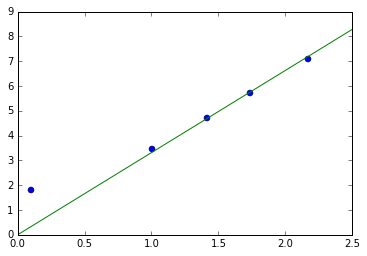

In [18]:
# Make square root fit for amplitudes that crosses zero at 59.70 pA
# See http://stackoverflow.com/a/9994484
x = np.sqrt(59.7-currents[-5:])
y = mean_amplitudes[-5:]
a, _, _, _ = np.linalg.lstsq(x[:, np.newaxis], y)
fit_amplitudes_slope = a[0]
print fit_amplitudes_slope

plt.plot(x, y, 'o')
plt.plot(np.linspace(0, 2.5), fit_amplitudes_slope * np.linspace(0, 2.5))

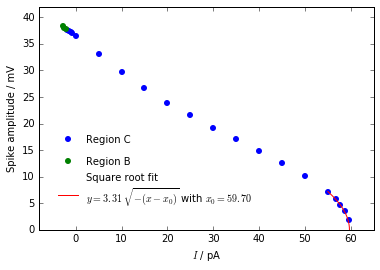

In [19]:
plt.plot(currents[num_decreasing:], mean_amplitudes[num_decreasing:], 'bo', markeredgecolor='none', label='Region C')  # yerr=sem_amplitudes
plt.plot(currents[:num_decreasing], mean_amplitudes[:num_decreasing], 'go', markeredgecolor='none', label='Region B')  # yerr=sem_amplitudes

plt.xlabel('$I$ / pA')
plt.ylabel('Spike amplitude / mV')
plt.xlim(-8, 65)
plt.ylim(0, 42)
#plt.axvline(-1.90+12, label="Rheobase (silence -> tonic)", color='b', alpha=0.6)
#plt.text(7, 25, '10.10 pA', color='b', rotation=90)

x = np.linspace(55, 59.7, 500)
plt.plot(x, fit_amplitudes_slope * np.sqrt(59.7 - x), 'r', linewidth=1, label='Square root fit\n$y = {0:.2f} \: \sqrt{{-(x - x_0)}}$ with $x_0 = 59.70$'.format(fit_amplitudes_slope), zorder=100)

plt.legend(loc='lower left', numpoints=1, borderaxespad=1.5, frameon=False, labelspacing=1.2)

plt.savefig("amplitudes.png", dpi=300)

# TODO: It seems like the amplitudes for high currents are shifted towards higher values. This could be because for these currents,
# multiple spikes at the beginning of the current step are higher than normal. See how the mean amplitude changes if we exclude
# the first few spikes.